### GenreBot : Using Natural Language Processing in Music Marketing

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition](./01_data_acquisition.ipynb)
- [Data Cleaning](./02_data_cleaning.ipynb)
- [Exploratory Data Analysis](./03_eda.ipynb)
- [Modeling](./04_modeling.ipynb)
- [Experiments](./04a_experiments.ipynb)
- Results and Recommendations (this notebook))

**In this notebook, you'll find:**
- Comparison of our models and selection of a production model
- Application of production model to our dataset for final classifications
- A quick look at a couple of misclassified documents
- Extraction of top terms based on classifications
- Conclusions/next steps

In [168]:
# usual imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# We'll see why we need this in a minute!

from sklearn.preprocessing import StandardScaler

# infrastructure
from sklearn.model_selection import train_test_split, GridSearchCV

# transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# supervised
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# heterogeneous-model supervised
from sklearn.ensemble import StackingClassifier

# evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

In [138]:
# import our model stats

df_stats = pd.read_csv('../data/model_stats.csv')


df_stats

,model,fit_time,train_acc,test_acc,recall,precision,f1
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.936810,0.917671,0.954071,0.935517
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719
3,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.929810,0.927752
4,TfidfVectorizer + Bagging,28.872257,0.992376,0.906319,0.884739,0.924465,0.904166
5,TfidfVectorizer + Random Forest,2.628158,0.914460,0.903310,0.841365,0.960128,0.896832
6,TfidfVectorizer + ExtraTrees,1.858499,0.921750,0.911735,0.897590,0.923554,0.910387
7,TfidfVectorizer + AdaBoost,7.388280,0.900482,0.895286,0.832129,0.952206,0.888127
8,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.962380,0.921273
9,TfidfVectorizer + LogReg/MNB/Grad Stack,15.633441,0.952782,0.937613,0.926908,0.947066,0.936878


- Let's explore our model stats via sorting/visualization!

In [139]:
# Who's got the best test set accuracy?

df_stats.sort_values(by = 'test_acc', ascending = False)

,model,fit_time,train_acc,test_acc,recall,precision,f1
12,TfidfVectorizer + Logreg/MNB stack,10.692293,0.957263,0.941424,0.931727,0.950041,0.940795
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719
9,TfidfVectorizer + LogReg/MNB/Grad Stack,15.633441,0.952782,0.937613,0.926908,0.947066,0.936878
11,TfidfVectorizer + Logreg/Grad stack,14.953498,0.957665,0.937212,0.922490,0.950352,0.936214
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.936810,0.917671,0.954071,0.935517
10,TfidfVectorizer + MNB/Grad stack,4.415673,0.945693,0.931996,0.922892,0.939877,0.931307
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356
3,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.929810,0.927752
8,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.962380,0.921273
6,TfidfVectorizer + ExtraTrees,1.858499,0.921750,0.911735,0.897590,0.923554,0.910387


**Conclusions:**
- As we saw as we went through our models, TFIDF + LogisticRegression and stacks using permutations of LogisticRegression, MultinomialNB, and GradientBoost are our winners here.
- Interesting that a CountVectorizer-based model made it into our top 10 as well!

In [140]:
# How about the delta between train and test?

df_stats['accuracy_delta'] = df_stats['train_acc'] - df_stats['test_acc']

df_stats.sort_values(by = 'accuracy_delta')

# No negative values for delta, so we're OK

,model,fit_time,train_acc,test_acc,recall,precision,f1,accuracy_delta
7,TfidfVectorizer + AdaBoost,7.388280,0.900482,0.895286,0.832129,0.952206,0.888127,0.005196
8,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.962380,0.921273,0.008546
6,TfidfVectorizer + ExtraTrees,1.858499,0.921750,0.911735,0.897590,0.923554,0.910387,0.010014
5,TfidfVectorizer + Random Forest,2.628158,0.914460,0.903310,0.841365,0.960128,0.896832,0.011150
3,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.929810,0.927752,0.013429
10,TfidfVectorizer + MNB/Grad stack,4.415673,0.945693,0.931996,0.922892,0.939877,0.931307,0.013697
9,TfidfVectorizer + LogReg/MNB/Grad Stack,15.633441,0.952782,0.937613,0.926908,0.947066,0.936878,0.015169
12,TfidfVectorizer + Logreg/MNB stack,10.692293,0.957263,0.941424,0.931727,0.950041,0.940795,0.015839
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719,0.017243
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.936810,0.917671,0.954071,0.935517,0.020185


**Conclusions:**
- The boosting models closed the variance gap the best, followed by the tree ensembles, single tree, MultinomialNB and some of our stacks.

In [141]:
# How about speed of fit?

df_stats.sort_values(by = 'fit_time')

,model,fit_time,train_acc,test_acc,recall,precision,f1,accuracy_delta
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356,0.043459
3,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.929810,0.927752,0.013429
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.936810,0.917671,0.954071,0.935517,0.020185
6,TfidfVectorizer + ExtraTrees,1.858499,0.921750,0.911735,0.897590,0.923554,0.910387,0.010014
8,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.962380,0.921273,0.008546
5,TfidfVectorizer + Random Forest,2.628158,0.914460,0.903310,0.841365,0.960128,0.896832,0.011150
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719,0.017243
10,TfidfVectorizer + MNB/Grad stack,4.415673,0.945693,0.931996,0.922892,0.939877,0.931307,0.013697
7,TfidfVectorizer + AdaBoost,7.388280,0.900482,0.895286,0.832129,0.952206,0.888127,0.005196
12,TfidfVectorizer + Logreg/MNB stack,10.692293,0.957263,0.941424,0.931727,0.950041,0.940795,0.015839


**Conclusions:**
- As we might expect, some of the simpler models fit more quickly.
- Our stacks don't show up so well on this ranking!

- We need to find the "sweet spot" that maximizes test accuracy and minimizes the accuracy delta (overfitting) and fit time.
- So we need an optimization technique to figure out which model to use!
- Proposed solution:
    - Create 2 new columns for inverse of accuracy delta and inverse of fit time
    - Scale those 2 columns, along with test accuracy, so they have the same magnitude
    - Create (somewhat arbitrary) weighting to prioritize the 3 variables
    - Choose the model with the maximum sum


In [142]:
# Create our inverse columns
df_stats['inv_accuracy_delta'] = df_stats['accuracy_delta'] ** -1
df_stats['inv_fit_time'] = df_stats['fit_time'] ** -1

# New dataset focusing on just what we need
df_opt_stats = df_stats[['test_acc', 'inv_accuracy_delta', 'inv_fit_time']]
df_opt_stats

,test_acc,inv_accuracy_delta,inv_fit_time
0,0.931795,23.010320,1.144158
1,0.936810,49.541031,0.668795
2,0.938014,57.995289,0.246553
3,0.927984,74.468103,0.771512
4,0.906319,11.620253,0.034635
5,0.903310,89.688719,0.380495
6,0.911735,99.856276,0.538069
7,0.895286,192.467464,0.135349
8,0.924574,117.019367,0.412895
9,0.937613,65.922194,0.063965


In [143]:
# Scale

ss = StandardScaler()
df_opt_stats_sc = pd.DataFrame(ss.fit_transform(df_opt_stats), columns = df_opt_stats.columns)

df_opt_stats_sc

,test_acc,inv_accuracy_delta,inv_fit_time
0,0.462207,-1.171828,2.412914
1,0.799774,-0.566334,0.935212
2,0.880790,-0.373388,-0.377356
3,0.205656,0.002561,1.254516
4,-1.252633,-1.431776,-1.036119
5,-1.455173,0.349932,0.039009
6,-0.888061,0.581980,0.528840
7,-1.995280,2.695587,-0.723042
8,-0.023889,0.973682,0.139729
9,0.853785,-0.192477,-0.944945


In [144]:
# Now we need some weights
# These are pretty arbitrary!
# So we're saying test accuracy is 2x as important as closing the overfitting gap
# And that's 2x as important as how long it takes to fit

weight_test_acc = 4
weight_inv_accuracy_delta = 2
weight_inv_fit_time = 1

df_opt_stats_sc['overall_score'] = weight_test_acc * df_opt_stats_sc['test_acc'] + \
    weight_inv_accuracy_delta * df_opt_stats_sc['inv_accuracy_delta'] + \
        weight_inv_fit_time * df_opt_stats_sc['inv_fit_time']

In [145]:
# Let's put the model names back in

df_opt_stats_sc['model'] = df_stats['model']

In [146]:
# Moment of truth...

df_opt_stats_sc.sort_values(by = 'overall_score', ascending = False)

,test_acc,inv_accuracy_delta,inv_fit_time,overall_score,model
12,1.110336,-0.256078,-0.853056,3.076131,TfidfVectorizer + Logreg/MNB stack
1,0.799774,-0.566334,0.935212,3.001640,TfidfVectorizer + LogisticRegression
2,0.880790,-0.373388,-0.377356,2.399028,TfidfVectorizer + tuned LogisticRegression
9,0.853785,-0.192477,-0.944945,2.085240,TfidfVectorizer + LogReg/MNB/Grad Stack
3,0.205656,0.002561,1.254516,2.082263,TFIDF + MultinomialNB
8,-0.023889,0.973682,0.139729,1.991535,TfidfVectorizer + GradientBoost
0,0.462207,-1.171828,2.412914,1.918086,CountVectorizer + LogisticRegression
10,0.475710,-0.030734,-0.439800,1.401572,TfidfVectorizer + MNB/Grad stack
11,0.826779,-0.581127,-0.935903,1.208960,TfidfVectorizer + Logreg/Grad stack
6,-0.888061,0.581980,0.528840,-1.859444,TfidfVectorizer + ExtraTrees


**Conclusions:**
- As we expected, our top candidates are TFIDF + LogisticRegression and related stacks.
- Let's go with #1! TFIDF + Logreg/MNB stack it is. It was our very last model!
- We will now recreate that model and fit it to our clean data, double-check the scores, and predict.

In [147]:
# This is a slightly modified version of the evaluation function used in the previous notebook

def evaluation(model, model_desc, X_train, y_train, X_test, y_test, normalize = 'pred'):
    '''
    Function to print and acquire some quick model stats.

    Parameters:
        model: the model
        model: description of the model
        X_train, y_train: Training features and target
        X_test, y_test: Testing features and target
        normalize: normalization for ConfusionMatrixDisplay
    Returns:
        Dataframe containing the model, fit time, training accuracy, testing accuracy, recall, precision, and F1
    '''

    start_time = time.time()
    model.fit(X_train, y_train)
    stop_time = time.time()
    fit_time = stop_time - start_time
    preds = model.predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    recall = recall_score(y_test, preds, pos_label = 1)
    precision = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)
    
    print(f'fit time: {fit_time}')
    print(f'training set accuracy: {train_acc}')
    print(f'test set accuracy: {test_acc}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1 score: {f1}')

In [148]:
# Redoing our couple of transformations on our clean posts to recreate our X and y and train-test split
df = pd.read_csv('../data/clean_posts.csv')

# We're focusing on just 2 classes, so let's drop the others
df = df[(df['subreddit'] == 'classicalmusic') | (df['subreddit'] == 'jazz')]

# let's encode our classes for efficiency
df['subreddit_code'] = df['subreddit'].astype('category').cat.codes

X = df['all_text']
y = df['subreddit_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

fit time: 10.132207870483398
training set accuracy: 0.9572632423756019
test set accuracy: 0.9414242728184554
recall: 0.9317269076305221
precision: 0.95004095004095
f1 score: 0.9407948094079481


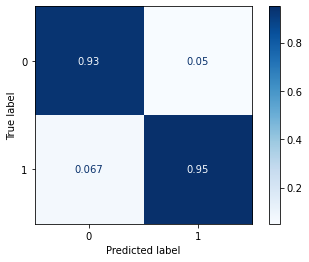

In [149]:
# recover our model

tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
mnb = MultinomialNB()

l1_estimators = [('logreg', logreg), ('mnb', mnb)]

stack = StackingClassifier(l1_estimators)
evaluation(stack, 'TfidfVectorizer + Logreg/MNB stack', X_vec_train, y_train, X_vec_test, y_test)

- Looks good!
- We're ready to merge our predictions back into the test data set, check out a few misclassifications, and find our top terms.
- Reminder that subreddit code 0 = classicalmusic, subreddit code 1 = jazz

In [151]:
X_test = pd.DataFrame(X_test, columns = ['all_text'])
X_test.head()

,all_text
18024,Pieces for saxophone
4302,Remote Music Lessons Survey I know this is tan...
2187,What are some of the greatest duos in Jazz his...
16216,Two great of the classical Hungarian music and...
11327,Does anybody know the name to this song I've b...


In [152]:
# Merge our predicted values

X_test['pred_subreddit_code'] = stack.predict(X_vec_test)

In [154]:
# translate our codes back into subreddits

X_test['pred_subreddit'] = X_test['pred_subreddit_code'].map({0: 'classicalmusic', 1: 'jazz'})
X_test.head()

,all_text,pred_subreddit_code,pred_subreddit
18024,Pieces for saxophone,0,classicalmusic
4302,Remote Music Lessons Survey I know this is tan...,0,classicalmusic
2187,What are some of the greatest duos in Jazz his...,1,jazz
16216,Two great of the classical Hungarian music and...,0,classicalmusic
11327,Does anybody know the name to this song I've b...,0,classicalmusic


In [156]:
# Merge our true values back in so we can look at a few misclassified items

X_test['true_subreddit'] = df['subreddit']
X_test.head()

,all_text,pred_subreddit_code,pred_subreddit,true_subreddit
18024,Pieces for saxophone,0,classicalmusic,classicalmusic
4302,Remote Music Lessons Survey I know this is tan...,0,classicalmusic,jazz
2187,What are some of the greatest duos in Jazz his...,1,jazz,jazz
16216,Two great of the classical Hungarian music and...,0,classicalmusic,classicalmusic
11327,Does anybody know the name to this song I've b...,0,classicalmusic,classicalmusic


In [158]:
# Create a column to indicate correct/incorrect predictions

X_test['pred_correct'] = X_test['pred_subreddit'] == X_test['true_subreddit']
X_test.head()

,all_text,pred_subreddit_code,pred_subreddit,true_subreddit,pred_correct
18024,Pieces for saxophone,0,classicalmusic,classicalmusic,True
4302,Remote Music Lessons Survey I know this is tan...,0,classicalmusic,jazz,False
2187,What are some of the greatest duos in Jazz his...,1,jazz,jazz,True
16216,Two great of the classical Hungarian music and...,0,classicalmusic,classicalmusic,True
11327,Does anybody know the name to this song I've b...,0,classicalmusic,classicalmusic,True


In [162]:
# How did our misclassifications compare between genres?

# jazz misclassified as classical
X_test[(X_test['pred_correct'] == False) & (X_test['true_subreddit'] == 'jazz')].count()

all_text               170
pred_subreddit_code    170
pred_subreddit         170
true_subreddit         170
pred_correct           170
dtype: int64

In [164]:
# classical misclassified as jazz
X_test[(X_test['pred_correct'] == False) & (X_test['true_subreddit'] == 'classicalmusic')].count()

all_text               122
pred_subreddit_code    122
pred_subreddit         122
true_subreddit         122
pred_correct           122
dtype: int64

In [166]:
# Let's export some of these so we can take a look later
X_test[(X_test['pred_correct'] == False) & (X_test['true_subreddit'] == 'jazz')].head(10).to_csv('../data/jazz_misclass.csv')
X_test[(X_test['pred_correct'] == False) & (X_test['true_subreddit'] == 'classicalmusic')].head(10).to_csv('../data/classical_misclass.csv')

**Conclusions:**
- The model was almost 1.5x as likely to misclassify jazz as it was to misclassify classical.
- We have a sample of 10 of each kind of misclassification for inclusion in our presentation.

- Now let's get our top terms from each genre.
- We won't distinguish between correct and incorrect predictions here - we want a realistic view of things, so we'll include both.
- Let's try for the top 10 words and top 10 bigrams from each.
- Probably easiest to use CountVectorizer to do this.

In [167]:
# Establish our genre datasets
jazz = X_test[X_test['pred_subreddit'] == 'jazz']
classical = X_test[X_test['pred_subreddit'] == 'classicalmusic']

In [186]:
# Get our CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range = (1, 2))

In [187]:
# Let's check out jazz
jazz_vec = cv.fit_transform(jazz['all_text'])
jazz_df = pd.DataFrame(jazz_vec.todense(), columns = cv.get_feature_names_out())

In [194]:
# Top 10 words

jazz_df[[col for col in jazz_df if len(col.split()) == 1]].sum().sort_values(ascending = False)[:10]

jazz       2753
like        936
music       719
know        637
just        620
ve          515
really      437
looking     420
play        372
new         363
dtype: int64

In [195]:
# Top 10 bigrams

jazz_df[[col for col in jazz_df if len(col.split()) == 2]].sum().sort_values(ascending = False)[:10]

miles davis       136
don know           92
big band           90
jazz music         75
does know          69
new jazz           67
john coltrane      60
jazz albums        58
charlie parker     55
feel like          54
dtype: int64

In [196]:
# Let's check out classical
classical_vec = cv.fit_transform(classical['all_text'])
classical_df = pd.DataFrame(classical_vec.todense(), columns = cv.get_feature_names_out())

In [197]:
# Top 10 words

classical_df[[col for col in classical_df if len(col.split()) == 1]].sum().sort_values(ascending = False)[:10]

music        1824
classical    1108
like          803
piece         676
pieces        639
piano         552
know          545
just          510
ve            426
help          355
dtype: int64

In [198]:
# Top 10 bigrams

classical_df[[col for col in classical_df if len(col.split()) == 2]].sum().sort_values(ascending = False)[:10]

classical music     600
don know             84
piano concerto       81
sheet music          55
th century           51
feel like            51
does know            50
ve heard             49
thanks advance       46
classical pieces     45
dtype: int64

**Conclusions:**
- We now have our final results, which are the top 10 words and bigrams used in each genre.
- The words aren't as useful - they're mostly pretty generic musical terms, and the presence of "classical" and "jazz" doesn't seem very helpful either.
- The bigrams are pretty telling, particularly in the jazz genre - we've got a few names of jazz musicians in there, along with "big band."

**FINAL NOTES/NEXT STEPS**:
- We've achieved our initial goal of predicting genres from posts and then extracting top terms from our predicted genres, using an optimized model that balances accuracy, overfitting, and speed pretty well.
- Looking at our extracted top terms, there are definitely a few useful gems in there, but we probably need to spend more time building stop words lists to make these as useful as possible.
- Other modeling options we could consider: unsupervised learning to cluster by genre, or principal component analysis (PCA) to reduce dimensionality.
- Making the model more useful: it's probably time to try a multi-class problem, since that would be more representative of the final application.
- See [Experiments](./04a_experiments.ipynb) for further work in these directions.